In [144]:
n_fold= 1
total_fold= '5'
use_enchanced_dataset= True
model_name= "SwinTransfrmr"

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm.notebook import tqdm

# Keras
import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from keras import backend as K
#from keras.applications.densenet import DenseNet121

import util
from sklearn.metrics import confusion_matrix, classification_report
from livelossplot import PlotLossesKeras
from keras.initializers import RandomNormal
from swintransformer import SwinTransformer

tf.compat.v1.disable_eager_execution()

In [92]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

print("Test built: {}".format(tf.test.is_built_with_cuda()))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Test built: True


In [93]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"
    
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

labels = ['No Findings',
          'Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

print("Leakage between train and test: {}".format(util.check_for_leakage(train_df, test_df, 'Image Index')))

Leakage between train and test: False


In [95]:
# Setting
seed= 1
set_batch_size= 8
# target_w= 320; target_h= 320; dim= (3,)
target_w= 224; target_h= 224; dim= (3,)
image_size_target= (target_w,target_h)
image_shape= image_size_target + dim
set_class_mode= 'raw'   # raw, categorical 

use_aug= False
use_normalize= True
index_col= "Image Index"
labels_col= labels

def prepare_generator(use_Aug, use_Normalize):
    # == Aug Image
    if use_Aug== True and use_Normalize== False:
        return ImageDataGenerator(
            rescale= 1./255,        
            horizontal_flip= True,
            height_shift_range= 0.5,
            width_shift_range= 0.5,
            vertical_flip= True,
            rotation_range= 20,
            fill_mode= "nearest"
            )
    # == Normalize Image
    if use_Aug== False and use_Normalize== True:
        return ImageDataGenerator(
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Without
    if use_Aug== False and use_Normalize== False:
        return ImageDataGenerator()

============ getting train generator ===========
Found 4484 validated image filenames.

==== getting train and test/valid generators ====
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


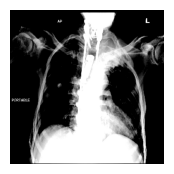

In [96]:
# === Image Train Generator
print("============ getting train generator ===========") 
image_train= prepare_generator(False, True).flow_from_dataframe(
    dataframe= train_df,
    directory= IMAGE_DIR,
    x_col= index_col,
    y_col= labels,
    class_mode= class_mode,
    batch_size= batch_size,
    shuffle= True,
    target_size= image_size_target
)

# === Image Validation and Test Generator
print("")
print("==== getting train and test/valid generators ====")
raw_train_generator= prepare_generator(False, False).flow_from_dataframe(
                        dataframe= train_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= True,
                        target_size= image_size_target
                    )
batch= raw_train_generator.next()
data_sample= batch[0]
imagegenerator= prepare_generator(False, True)
imagegenerator.fit(data_sample)
image_val = imagegenerator.flow_from_dataframe(
                        dataframe= test_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= False,
                        target_size= image_size_target
                    )

x, y = image_train.__getitem__(0)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x[0]);

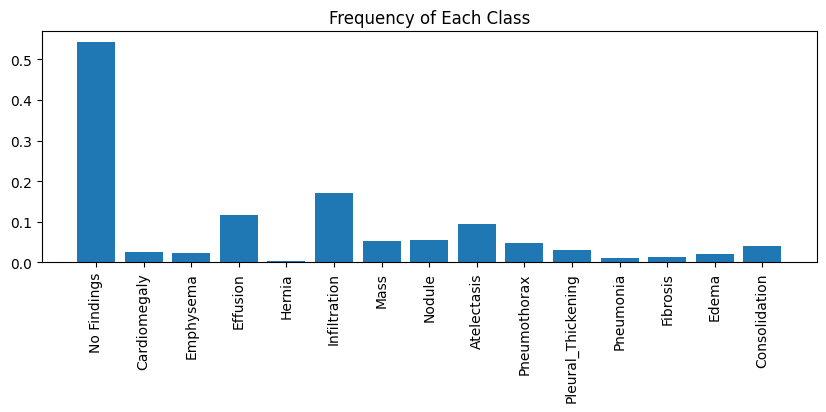

In [97]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(image_train.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [102]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(image_train.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

/tmp/ipykernel_26174/3905682285.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


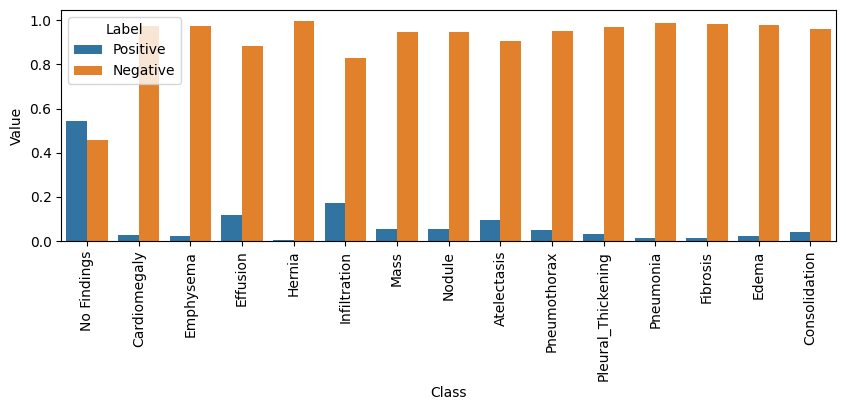

In [104]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_26174/1531308047.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


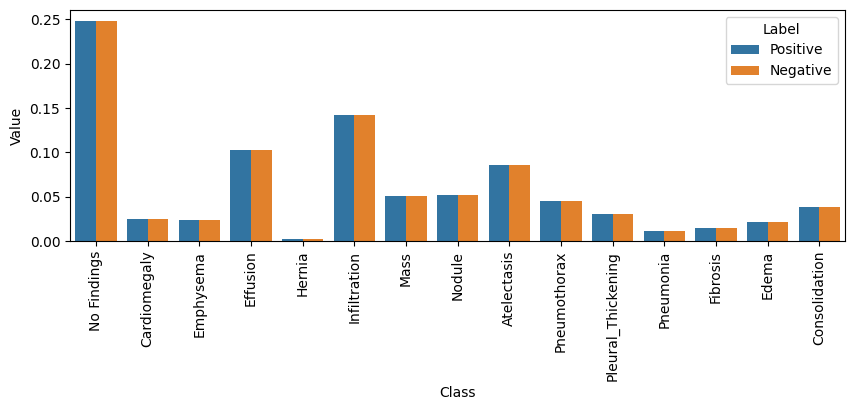

In [107]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [145]:
inputs= Input(shape=image_shape)
swin = SwinTransformer('swin_tiny_224', include_top=False, pretrained=True)(inputs)
swin_output = Flatten()(swin)

Swin_Model = Model(inputs, swin_output, name="Swin")
Swin_Model.trainable = False

TypeError: in user code:

    File "/home/cries/Workshop/X-Ray/TransX-Ray/swintransformer/model.py", line 422, in call  *
        x = self.forward_features(x)
    File "/home/cries/Workshop/X-Ray/TransX-Ray/swintransformer/model.py", line 416, in forward_features  *
        x = self.basic_layers(x)
    File "/home/cries/Workshop/X-Ray/TransX-Ray/swintransformer/model.py", line 307, in call  *
        x = self.blocks(x)
    File "/home/cries/.conda/envs/Nabil_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/cries/Workshop/X-Ray/TransX-Ray/swintransformer/model.py", line 195, in build
        attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)

    TypeError: Input 'e' of 'SelectV2' Op has type float64 that does not match type float32 of argument 't'.


In [ ]:
MobileNet_V3 = tf.keras.applications.MobileNetV3Small(weights='imagenet', 
                                                      alpha=1.0, 
                                                      include_top=False)(inputs)

outputs = -MaxPooling2D(pool_size=(2, 2),padding='same', name="MB_MinPooling2D")(-MobileNet_V3)
outputs = Flatten()(outputs)
mb3_Model = Model(inputs=inputs, outputs=outputs, name="MobileNet-V3")
mb3_Model.trainable = False

In [ ]:
merged_neck = keras.layers.concatenate([Swin_Model.output, mb3_Model.output])
neck = BatchNormalization()(merged_neck)

dense = Dense(16, activation='LeakyReLU')(neck)
dense = Dense(4)(dense)
dense = Dense(16, activation='LeakyReLU')(dense)

merged_head = keras.layers.concatenate([neck, dense])

head = Dense(32, activation='LeakyReLU')(merged_head)
head = Dense(8)(head)
head = Dense(32, activation='LeakyReLU')(head)

head = Dense(num_class, activation='softmax')(head)

model = Model(inputs=inputs, outputs=head)

In [ ]:
epoch = 25

lr = 1e-4
decay_rate = lr / epoch
momentum = 0.99
adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, decay=decay_rate, nesterov=False)
checkpoint = ModelCheckpoint("ckp_{}.hdf5".format(model_name), monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

cce_ls = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(loss=cce_ls, optimizer=sgd, metrics=['accuracy'])

In [ ]:
start = time.time()
history = model.fit(image_train, epochs=epoch, validation_data=image_val, callbacks=[checkpoint,PlotLossesKeras()],verbose=1)
end_train = time.time() - start

In [ ]:
model.save('model_{}'.format(model_name))

In [ ]:
model.save_weights("{}_weights.h5".format(model_name))
file_stats = os.stat("{}_weights.h5".format(model_name))
model_size = round(file_stats.st_size / (1024 * 1024), 2)
model_parameter = model.count_params()

In [ ]:
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
#Load Model
from tensorflow import keras
model_fusion = keras.models.load_model('./model_{}/'.format(model_name))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

start = time.time()
y_prob = model_fusion.predict(image_val)
end_test = time.time() - start

y_pred = np.argmax(y_prob, axis=1)
y_true = image_val.classes

print("Precision:", precision_score(y_true, y_pred, average='weighted'), "Recall:", recall_score(y_true, y_pred, average='weighted'))

cm = multilabel_confusion_matrix(y_true, y_pred)

a = []

for i in range(len(cm)):
    a.append(cm[i].ravel())

tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

print("tp, fn, fp, tn:", tp, fn, fp, tn)

print("Specificity:", tn / (tn+fp), "Sensitivity:", tp / (tp+fn))
print("F1-Score:", f1_score(y_true, y_pred, average='weighted'), "Accuracy:", accuracy_score(y_true, y_pred))

Specificty = tn / (tn+fp)
Sensitivity = tp / (tp+fn)
F1_Score = f1_score(y_true, y_pred, average='weighted')
Accuracy = accuracy_score(y_true, y_pred)

In [ ]:
result = [y_true, y_pred]
pd.DataFrame(result).to_csv("{}_{}_result.csv".format(model_name, n_fold))
pd.DataFrame(y_prob).to_csv("{}_{}_probability.csv".format(model_name, n_fold))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
m_auc = roc_auc_score(y_true, y_pred)

print(fpr_keras, tpr_keras, thresholds_keras, m_auc)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

In [ ]:
# keep probabilities for the positive outcome only
lr_probs = y_prob[:, 1]
lr_auc = roc_auc_score(y_true, lr_probs)
print('Model Fusion: ROC AUC=%.3f' % (lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)

plt.figure(figsize=(10, 10))
font={'size':'15'}
plt.rc('font',**font)

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='{} Model ROC curve (area = %0.2f)'.format(model_name) % lr_auc)

roc_auc = [lr_fpr, lr_fpr]
pd.DataFrame(roc_auc).to_csv("{}_roc_auc.csv".format(model_name))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

AUC_Score = lr_auc

In [ ]:
Result = [Specificty, Sensitivity, F1_Score, Accuracy, AUC_Score, end_train, end_test, model_size, model_parameter]
colname = ['Specificty', 'Sensitivity', 'F1_Score', 'Accuracy', 'AUC_Score', 'end_train', 'end_test', 'model_size', 'model_parameter']

pd.DataFrame([Result], columns=colname).to_csv("{}_fold_".format(model_name)+str(n_fold)+".csv")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

labels = ["Sperm", "Impurity"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.rcParams['figure.figsize']=[15,15]
font={'size':'30'}
plt.rc('font',**font)
disp.plot(cmap=plt.cm.Blues)

# Old Program

In [109]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320): 
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [110]:
def get_test_generator(test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image Index",
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [111]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", labels)
test_generator= get_test_generator(test_df, train_df, IMAGE_DIR, "Image Index", labels)

getting train generator...
Found 4484 validated image filenames.
getting train generators...
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


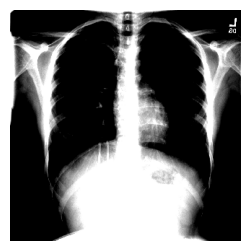

In [112]:
x, y = train_generator.__getitem__(0)
plt.figure(figsize=(5,3))
plt.axis('off')
plt.imshow(x[0]);

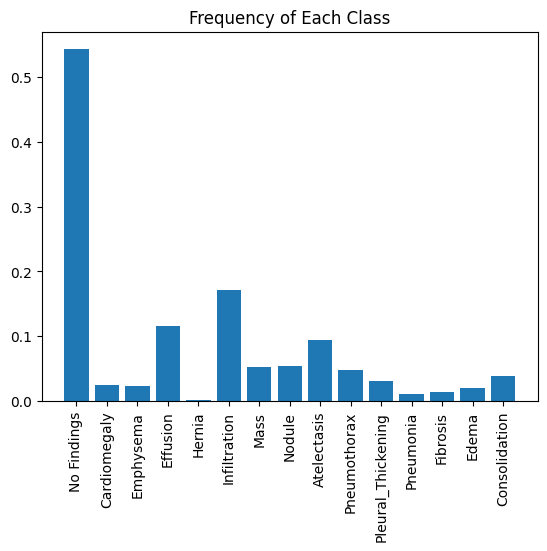

In [113]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [114]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [115]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

/tmp/ipykernel_26174/2978771470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


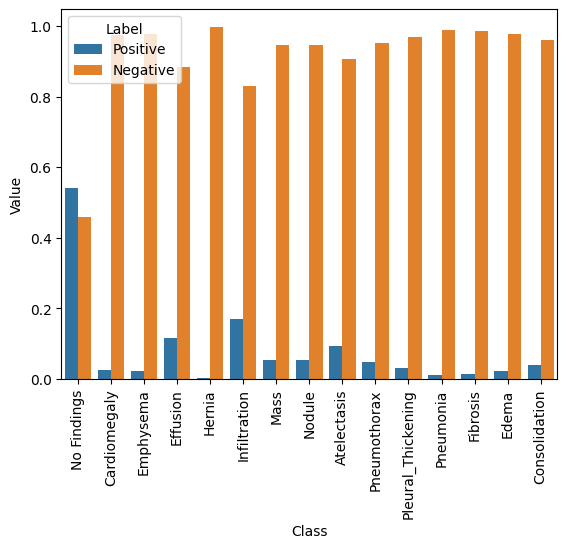

In [116]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [117]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

/tmp/ipykernel_26174/4211278599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


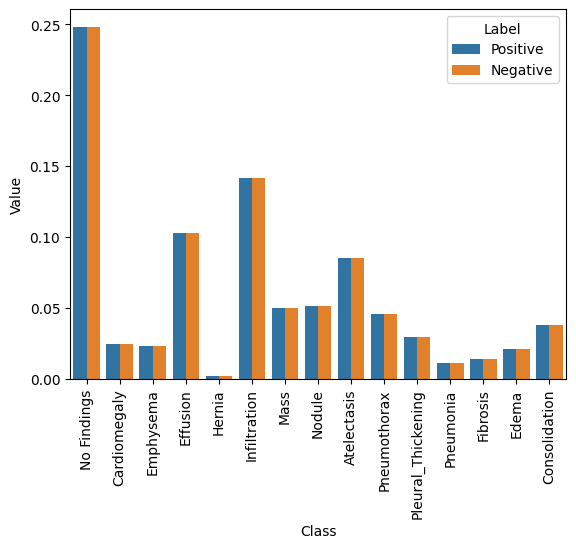

In [118]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [119]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss

    return weighted_loss

In [121]:
from keras.applications.densenet import DenseNet121

# create the base pre-trained model
base_model = DenseNet121(weights='/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
Colocations handled automatically by placer.


2022-11-18 08:15:22.566990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 08:15:23.674447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22018 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2022-11-18 08:15:24.070089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [122]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

Epoch 1/25


/tmp/ipykernel_26174/1411956005.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-11-18 08:16:15.420916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-18 08:16:17.026727: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-18 08:16:17.030586: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-18 08:16:17.030648: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-18 08:16:17.030821: W tensorflow/str

561/561 [==============================] - 207s 304ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2721
Epoch 2/25
561/561 [==============================] - 170s 303ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2309
Epoch 3/25
561/561 [==============================] - 171s 304ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2175
Epoch 4/25
561/561 [==============================] - 171s 304ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.2049
Epoch 5/25
561/561 [==============================] - 171s 304ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.1998
Epoch 6/25
561/561 [==============================] - 171s 305ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.1936
Epoch 7/25
561/561 [==============================] - 171s 304ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.1956
Epoch 8/25
561/561 [==============================] - 171s 305ms/step - batch: 280.0000 - size: 7.9929 - loss: 1.1872
Epoch 9/25
561/561 [==============================] - 171s 304ms/st

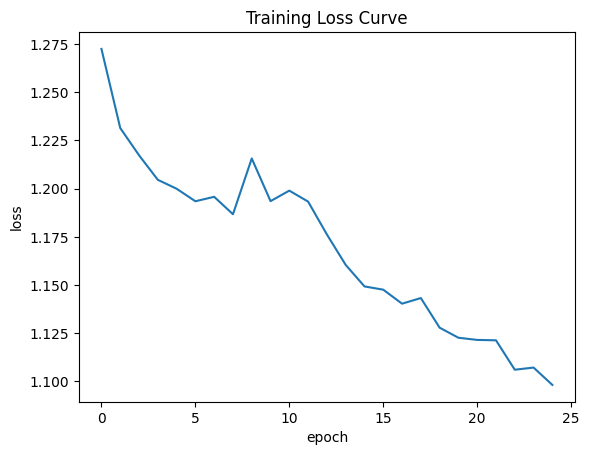

In [123]:
history = model.fit_generator(train_generator, 
                              #validation_data=valid_generator,
                              #steps_per_epoch=100, # to limit step
                              #validation_steps=25, 
                              epochs = 25)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

### Training on the Larger Dataset 

In [124]:
# model.load_weights("/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels.h5")

### Prediction and Evaluation

In [125]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

/tmp/ipykernel_26174/2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
/home/cries/.conda/envs/Nabil_env/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### ROC Curve and AUROC

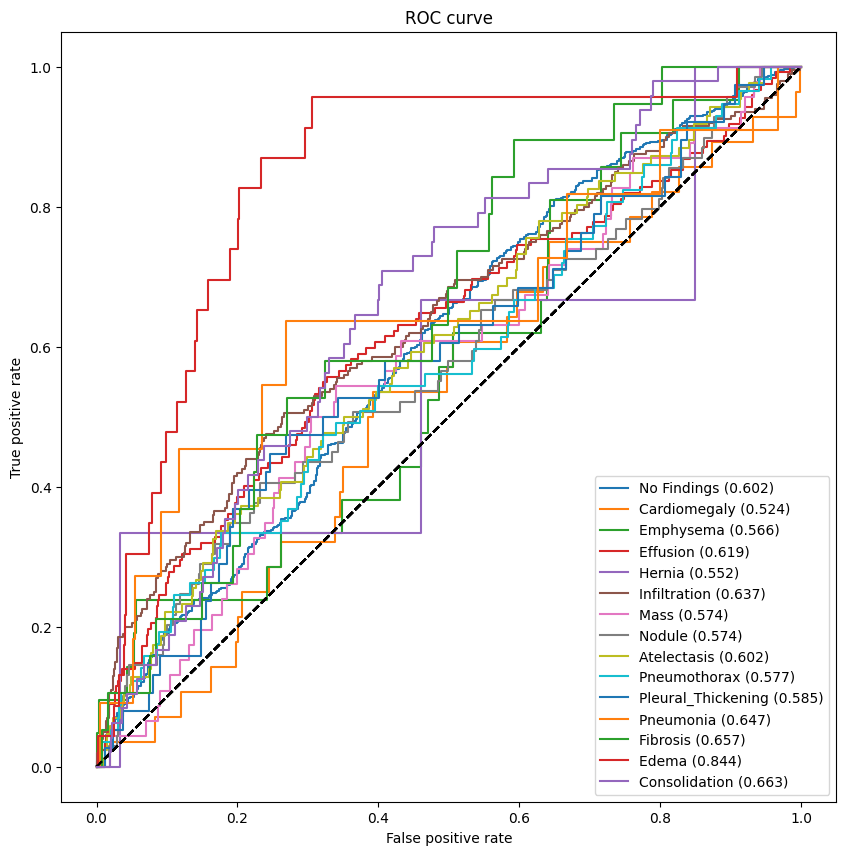

In [126]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [135]:
#release memory GPU

from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


### Visualizing Learning with GradCAM

In [128]:
# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [129]:
# util.compute_gradcam(model, '00000013_005.png', IMAGE_DIR, train_df, labels, labels_to_show)